In [ ]:
import os
import gc
from tqdm import tqdm
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "DejaVu Serif"
import matplotlib as mpl
import math

# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"

Snapshot_Init = 33
Snapshot_End = 99
Lbsg_Indcies_Array = np.array(
    [117251, 300903, 324123, 329508, 382215,
        400973, 419618, 457431, 460722, 490814]
)

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3

Redshift = np.array([20.05, 14.99, 11.98, 10.98, 10.00, 9.39, 9.00, 8.45, 8.01, 7.60,
                     7.24, 7.01, 6.49, 6.01, 5.85, 5.53, 5.23, 5.00, 4.66, 4.43,
                     4.18, 4.01, 3.71, 3.49, 3.28, 3.01, 2.90, 2.73, 2.58, 2.44,
                     2.32, 2.21, 2.10, 2.00, 1.90, 1.82, 1.74, 1.67, 1.60, 1.53,
                     1.50, 1.41, 1.36, 1.30, 1.25, 1.21, 1.15, 1.11, 1.07, 1.04,
                     1.00, 0.95, 0.92, 0.89, 0.85, 0.82, 0.79, 0.76, 0.73, 0.70,
                     0.68, 0.64, 0.62, 0.60, 0.58, 0.55, 0.52, 0.50, 0.48, 0.46,
                     0.44, 0.42, 0.40, 0.38, 0.36, 0.35, 0.33, 0.31, 0.30, 0.27,
                     0.26, 0.24, 0.23, 0.21, 0.20, 0.18, 0.17, 0.15, 0.14, 0.13,
                     0.11, 0.10, 0.08, 0.07, 0.06, 0.05, 0.03, 0.02, 0.01, 0.00])

Host_Index_At_99 = 329508

Host_Index_At_98 = 329045
Satellite_Index_At_98 = 329051

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "DejaVu Serif"

In [ ]:
gas_dict=il.snapshot.loadSubhalo(basePath,99,329508,'Gas',['Coordinates','Masses','NeutralHydrogenAbundance','Velocities'])
subhalo_dict=il.groupcat.loadSingle(basePath,99,-1,329508)

In [ ]:
y = 20200
z = 22000

total_range =300
num_slices =10
bin_width = total_range / num_slices

ymin = y - total_range / 2
zmin = z - total_range / 2

num_bins = int(50 * bin_width)
fig, axes = plt.subplots(num_slices, num_slices, figsize=(12, 12), sharey=True, sharex=True)

for row_index in range(num_slices):
    for col_index in range(num_slices):
        ax = axes[num_slices - col_index - 1, row_index]
#        if row_index == 4 and col_index==7:continue
#        if row_index==5 and col_index==7:continue
        y_range = [ymin + row_index * bin_width, ymin + (row_index + 1) * bin_width]
        z_range = [zmin + col_index * bin_width, zmin + (col_index + 1) * bin_width]

        gas_indices = np.where(
            (gas_dict['Coordinates'][:, 1] > y_range[0]) & (gas_dict['Coordinates'][:, 1] < y_range[1]) &
            (gas_dict['Coordinates'][:, 2] > z_range[0]) & (gas_dict['Coordinates'][:, 2] < z_range[1])
        )[0]

        gas_mass = gas_dict['Masses'][gas_indices]
        gas_velocity = gas_dict['Velocities'][gas_indices]
        gas_HI_abundance = gas_dict['NeutralHydrogenAbundance'][gas_indices]

        gas_velocity = gas_velocity - subhalo_dict['SubhaloVel']
        gas_velocity = np.linalg.norm(gas_velocity, axis=1)
        gas_HI_mass = gas_mass * gas_HI_abundance

        hist_values, bin_edges = np.histogram(gas_velocity, bins=num_bins, weights=gas_HI_mass)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(bin_centers, hist_values, color='skyblue', linestyle='-')
        ax.set_facecolor('black')
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.set_xticks([])
        ax.set_yticks([])
plt.style.use('dark_background')
plt.tight_layout()
plt.show()


In [11]:
class Cell:
    def __init__(self):
        self.Coordinate = np.array([0.0, 0.0, 0.0])
        self.Mass = 0.0


class Cloud:
    def __init__(self, x_range, y_range):
        x_min, x_max = x_range
        y_min, y_max = y_range
        x_centers = np.arange(x_min + 0.0625, x_max, 0.125)
        y_centers = np.arange(y_min + 0.0625, y_max, 0.125)
        xx, yy = np.meshgrid(x_centers, y_centers)
        self.cells = [Cell() for _ in range(xx.size)]
        self.x_range = x_range
        self.y_range = y_range
        self.assign_coordinates(xx.flatten(), yy.flatten())

    def assign_coordinates(self, x_coords, y_coords):
        for i, cell in enumerate(self.cells):
            cell.Coordinate = np.array([0.0, x_coords[i], y_coords[i]])

    def assign_mass(self, coordinates: np.ndarray, masses: np.ndarray):
        x_min, x_max = self.x_range
        y_min, y_max = self.y_range
        x_bars = int((x_max - x_min) / 0.125)
        for i in range(coordinates.shape[0]):
            coord = coordinates[i]
            mass = masses[i]
            x_index = int((coord[1] - x_min) / 0.125)
            y_index = int((coord[2] - y_min) / 0.125)

            index = y_index * x_bars + x_index
            if (index>= len(self.cells)):continue
            if (index<0):continue
            self.cells[index].Mass += mass

    def visualize(self, savePath):
        plt.figure(figsize=(20, 20), dpi=300)
        plt.style.use("dark_background")
        x_range, y_range = self.x_range, self.y_range
        plt.hist2d([cell.Coordinate[1] for cell in self.cells], [cell.Coordinate[2] for cell in self.cells], norm=mpl.colors.LogNorm(),cmin=0.00005, bins=[int((y_range[1]-y_range[0])*2), int((x_range[1]-x_range[0])*2)], weights=[cell.Mass for cell in self.cells])
        plt.xlabel('y [ckpc/h]')
        plt.ylabel('z [ckpc/h]')
        plt.ylim(self.x_range[0],self.x_range[1])
        plt.xlim(self.y_range[0],self.y_range[1])
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        plt.axis('equal')
        plt.savefig(savePath)
        plt.close('all')

    def reset(self):
        for cell in self.cells:
            cell.Coordinate = np.array([0.0, 0.0, 0.0])
            cell.Mass = 0.0

    def clear_value(self,value):
        for cell in self.cells:
            if cell.Mass>value:
                cell.Mass=0.0


In [ ]:

y=20220
z=22040
total_range=300
ymin = y - total_range / 2
ymax = y + total_range / 2
zmin = z - total_range / 2
zmax = z + total_range / 2

cloud=Cloud([ymin,ymax],[zmin,zmax])

In [ ]:
gas_indices = np.where(
            (gas_dict['Coordinates'][:, 1] > ymin) & (gas_dict['Coordinates'][:, 1] < ymax) &
            (gas_dict['Coordinates'][:, 2] > zmin) & (gas_dict['Coordinates'][:, 2] < zmax)
        )[0]

gas_mass = gas_dict['Masses'][gas_indices]
gas_HI_abundance = gas_dict['NeutralHydrogenAbundance'][gas_indices]
gas_coordinates = gas_dict['Coordinates'][gas_indices]

gas_HI_mass = gas_mass * gas_HI_abundance

In [ ]:
cloud.assign_mass(gas_coordinates,gas_mass)

In [ ]:
plt.style.use("dark_background")
plt.figure(figsize=(20, 20), dpi=300)
x_range, y_range = cloud.x_range, cloud.y_range
plt.hist2d([cell.Coordinate[1] for cell in cloud.cells], [cell.Coordinate[2] for cell in cloud.cells], norm=mpl.colors.LogNorm(), bins=[int((x_range[1]-x_range[0])*8), int((y_range[1]-y_range[0])*8)], weights=[cell.Mass for cell in cloud.cells],cmin=1e-6,cmap='gray')
plt.xlabel('y [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.xlim(cloud.x_range[0],cloud.x_range[1])
plt.ylim(cloud.y_range[0],cloud.y_range[1])
#plt.axes().get_xaxis().set_visible(False)
#plt.axes().get_yaxis().set_visible(False)
plt.axis('equal')

In [ ]:
y=20220
z=22040
total_range =300
num_slices =10
bin_width = total_range / num_slices
ymin = y - total_range / 2
zmin = z - total_range / 2

num_bins = int(50 * bin_width)
fig, axes = plt.subplots(num_slices, num_slices, figsize=(20,20), sharey=True, sharex=True)

for row_index in range(num_slices):
    for col_index in range(num_slices):
        ax = axes[num_slices - col_index - 1, row_index]

        y_range = [ymin + row_index * bin_width, ymin + (row_index + 1) * bin_width]
        z_range = [zmin + col_index * bin_width, zmin + (col_index + 1) * bin_width]

        gas_indices = np.where(
            (gas_dict['Coordinates'][:, 1] > y_range[0]) & (gas_dict['Coordinates'][:, 1] < y_range[1]) &
            (gas_dict['Coordinates'][:, 2] > z_range[0]) & (gas_dict['Coordinates'][:, 2] < z_range[1])
        )[0]

        gas_mass = gas_dict['Masses'][gas_indices]
        gas_velocity = gas_dict['Velocities'][gas_indices]
        gas_HI_abundance = gas_dict['NeutralHydrogenAbundance'][gas_indices]

        gas_velocity = gas_velocity# - subhalo_dict['SubhaloVel']
        gas_velocity = np.linalg.norm(gas_velocity, axis=1)
        gas_HI_mass = gas_mass * gas_HI_abundance

        indice=np.where(gas_velocity<1000)[0]
        gas_velocity=gas_velocity[indice]
        gas_HI_mass=gas_HI_mass[indice]


        hist_values, bin_edges = np.histogram(gas_velocity, bins=num_bins, weights=gas_HI_mass)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(bin_centers, hist_values, color='skyblue', linestyle='-')
        ax.set_facecolor('black')

        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')

        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.set_xticks([])
        ax.set_yticks([])
plt.style.use('dark_background')
plt.tight_layout()
plt.show()

In [4]:
stellar_dict=il.snapshot.loadSubhalo(basePath,99,329508,'Stars',['Coordinates','Masses','Velocities'])

In [12]:
y=20220
z=22040
total_range=300
ymin = y - total_range / 2
ymax = y + total_range / 2
zmin = z - total_range / 2
zmax = z + total_range / 2

cloud=Cloud([ymin,ymax],[zmin,zmax])

In [13]:
cloud.assign_mass(stellar_dict['Coordinates'],stellar_dict['Masses'])

(20070.0625, 20369.9375, 21890.0625, 22189.9375)

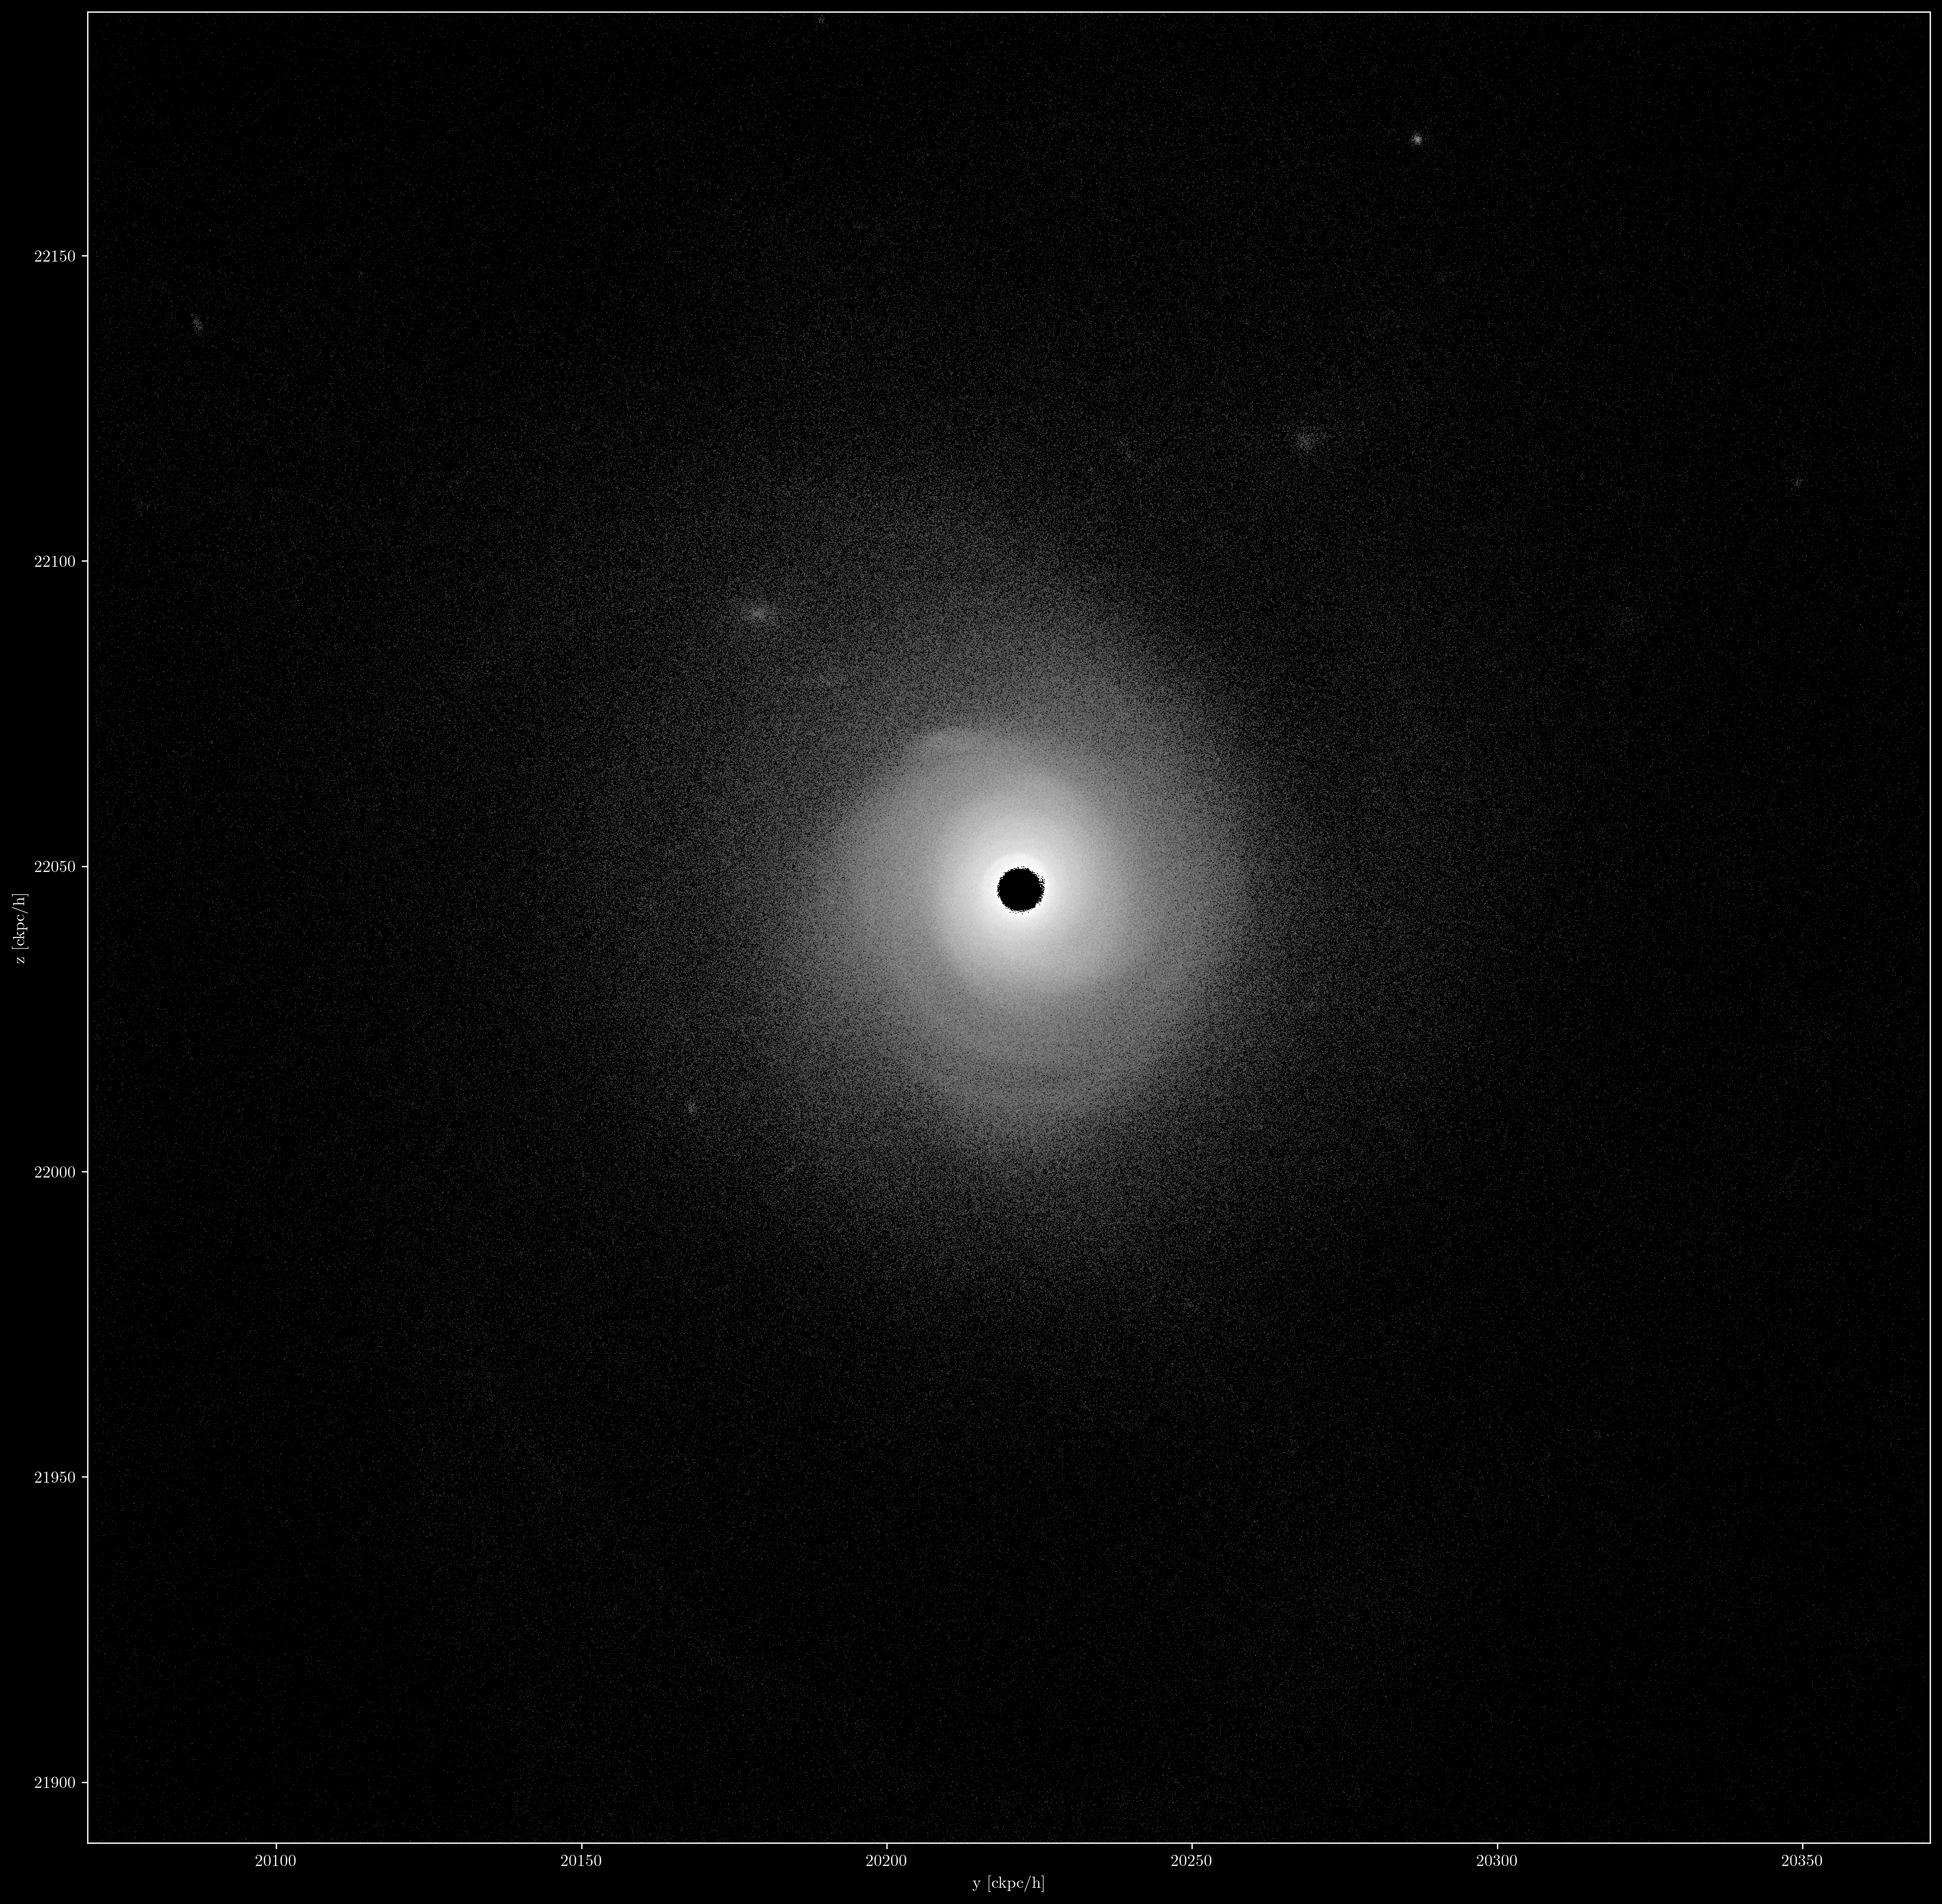

In [17]:
plt.figure(figsize=(20, 20), dpi=300)
plt.style.use("dark_background")
x_range, y_range = cloud.x_range, cloud.y_range
plt.hist2d([cell.Coordinate[1] for cell in cloud.cells], [cell.Coordinate[2] for cell in cloud.cells], norm=mpl.colors.LogNorm(), bins=[int((x_range[1]-x_range[0])*8), int((y_range[1]-y_range[0])*8)], weights=[cell.Mass for cell in cloud.cells],cmin=1e-6,cmap='gray')
plt.xlabel('y [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.xlim(cloud.x_range[0],cloud.x_range[1])
plt.ylim(cloud.y_range[0],cloud.y_range[1])
#plt.axes().get_xaxis().set_visible(False)
#plt.axes().get_yaxis().set_visible(False)
plt.axis('equal')